# Importing necessary libs

In [36]:
# import scipy.stats as stats
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

# Loading the data

In [37]:
df = "./data/mem_cpu_ten.csv"

names = ['env', 'cpu_percentage', 'memory_percentage', 'memory_usage', 'net_io', 'block_io', 'pids', 'timestamp']
df = pd.read_csv(df, header=None, names=names, delimiter=';')

df.head()

,env,cpu_percentage,memory_percentage,memory_usage,net_io,block_io,pids,timestamp
0,deno,0.00%,0.37%,119.2MiB / 31.18GiB,491MB / 2.37GB,0B / 176kB,9,21:24:50
1,node,164.35%,0.26%,81.73MiB / 31.18GiB,191MB / 1.01GB,0B / 4.1kB,23,21:24:50
2,bun,0.00%,1.11%,353.3MiB / 31.18GiB,644MB / 3.53GB,0B / 0B,13,21:24:50
3,deno,0.00%,0.37%,119.2MiB / 31.18GiB,491MB / 2.37GB,0B / 176kB,9,21:24:53
4,node,128.14%,0.26%,81.75MiB / 31.18GiB,192MB / 1.02GB,0B / 4.1kB,23,21:24:53


In [38]:
float_columns = ['cpu_percentage', 'memory_percentage']

for column in float_columns:
    df[column] = df[column].str.replace('%', '')
    df[column] = df[column].astype(float)

df['timestamp'] = pd.to_datetime(df['timestamp'], format='%H:%M:%S')

print(df.dtypes)

df.head()


env                          object
cpu_percentage              float64
memory_percentage           float64
memory_usage                 object
net_io                       object
block_io                     object
pids                          int64
timestamp            datetime64[ns]
dtype: object


,env,cpu_percentage,memory_percentage,memory_usage,net_io,block_io,pids,timestamp
0,deno,0.00,0.37,119.2MiB / 31.18GiB,491MB / 2.37GB,0B / 176kB,9,1900-01-01 21:24:50
1,node,164.35,0.26,81.73MiB / 31.18GiB,191MB / 1.01GB,0B / 4.1kB,23,1900-01-01 21:24:50
2,bun,0.00,1.11,353.3MiB / 31.18GiB,644MB / 3.53GB,0B / 0B,13,1900-01-01 21:24:50
3,deno,0.00,0.37,119.2MiB / 31.18GiB,491MB / 2.37GB,0B / 176kB,9,1900-01-01 21:24:53
4,node,128.14,0.26,81.75MiB / 31.18GiB,192MB / 1.02GB,0B / 4.1kB,23,1900-01-01 21:24:53


# Creating time_elapsed field to plot better graphics

Without this field, it would be impossible to overlap the lines of each test, because each test happened sequentially.
It was also necessary to remove any log where cpu utilization was less than 1% because these idle stretches represent the moments when the runtime wasn't being tested.

In [39]:
df['time_elapsed'] = 0

filtered_df = df[df['cpu_percentage'] >= 1]

node_min = filtered_df[filtered_df['env'] == 'node']['timestamp'].min()
bun_min = filtered_df[filtered_df['env'] == 'bun']['timestamp'].min()
deno_min = filtered_df[filtered_df['env'] == 'deno']['timestamp'].min()

print("Start time - node test:", node_min)
print("Start time - bun test:", bun_min)
print("Start time - deno test:", deno_min)

def determine_time_elapsed(start, timestamp):
    return (timestamp - start).seconds

filtered_df.loc[filtered_df['env'] == 'node', 'time_elapsed'] = (filtered_df['timestamp'] - node_min).dt.total_seconds()
filtered_df.loc[filtered_df['env'] == 'bun', 'time_elapsed'] = (filtered_df['timestamp'] - bun_min).dt.total_seconds()
filtered_df.loc[filtered_df['env'] == 'deno', 'time_elapsed'] = (filtered_df['timestamp'] - deno_min).dt.total_seconds()

filtered_df = filtered_df[filtered_df['time_elapsed'] >= 0]

filtered_df.head()

Start time - node test: 1900-01-01 21:24:50
Start time - bun test: 1900-01-01 21:30:52
Start time - deno test: 1900-01-01 21:36:51


,env,cpu_percentage,memory_percentage,memory_usage,net_io,block_io,pids,timestamp,time_elapsed
1,node,164.35,0.26,81.73MiB / 31.18GiB,191MB / 1.01GB,0B / 4.1kB,23,1900-01-01 21:24:50,0
4,node,128.14,0.26,81.75MiB / 31.18GiB,192MB / 1.02GB,0B / 4.1kB,23,1900-01-01 21:24:53,3
7,node,133.63,0.27,85.3MiB / 31.18GiB,194MB / 1.03GB,0B / 4.1kB,23,1900-01-01 21:24:56,6
10,node,128.20,0.26,82.4MiB / 31.18GiB,195MB / 1.03GB,0B / 4.1kB,23,1900-01-01 21:24:59,9
13,node,126.00,0.25,80.81MiB / 31.18GiB,196MB / 1.04GB,0B / 4.1kB,23,1900-01-01 21:25:02,12


In [40]:
def plot_line(df: pd.DataFrame, x: str, y: str, hue: str, x_label: str, y_label: str, segment_by_time: list = None):
    """
    Plots a line graph using data from the given dataframe.
    
    Receives:
        df: Dataframe
        x: str (df column name to be plotted agains the x-axis)
        y: str (df column name to be plotted agains the y-axis)
        hue: str (df column name to distinguish different bars by color)
        x_label: str (displayed as the label for x-axis)
        y_label: str (displayed as the label for y-axis)
        segment_by_time: list of tuples [(int, str), ...] (optional, but if present plots vertical lines on the given int with the label).
    """
    plt.figure(figsize=(14, 7))
    fig = sns.lineplot(data=df, x=x, y=y, hue=hue)
    fig.set(xlabel=x_label, ylabel=y_label)
    
    # Creates vertical straight lines on the graph to highlight some specific timestamp.
    if segment_by_time is not None:
        for (time, time_label) in segment_by_time:
            plt.axvline(x=time, color='red', linestyle='--')
            plt.text(time, df[y].max(), time_label, color='red', ha='left', va='bottom', rotation=0)

    plt.show()

# Test context change timestamp
Each test run for 2 minutes (120 seconds), and then stopped so that the next in line could run.

It's important to highlight this change in the graph.

In [41]:
test_time_segments = [(120, "  first test"), (240, "  second test")]

# cpu usage

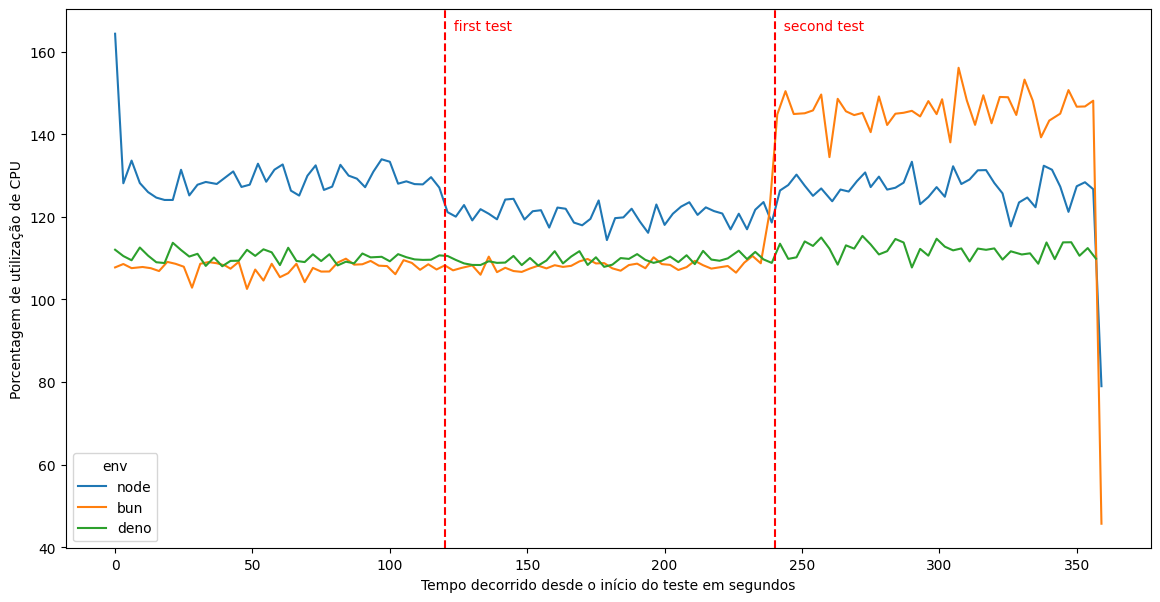

In [42]:
plot_line(filtered_df, 'time_elapsed', 'cpu_percentage', 'env', 'Tempo decorrido desde o início do teste em segundos', 'Porcentagem de utilização de CPU', test_time_segments)

# mem usage

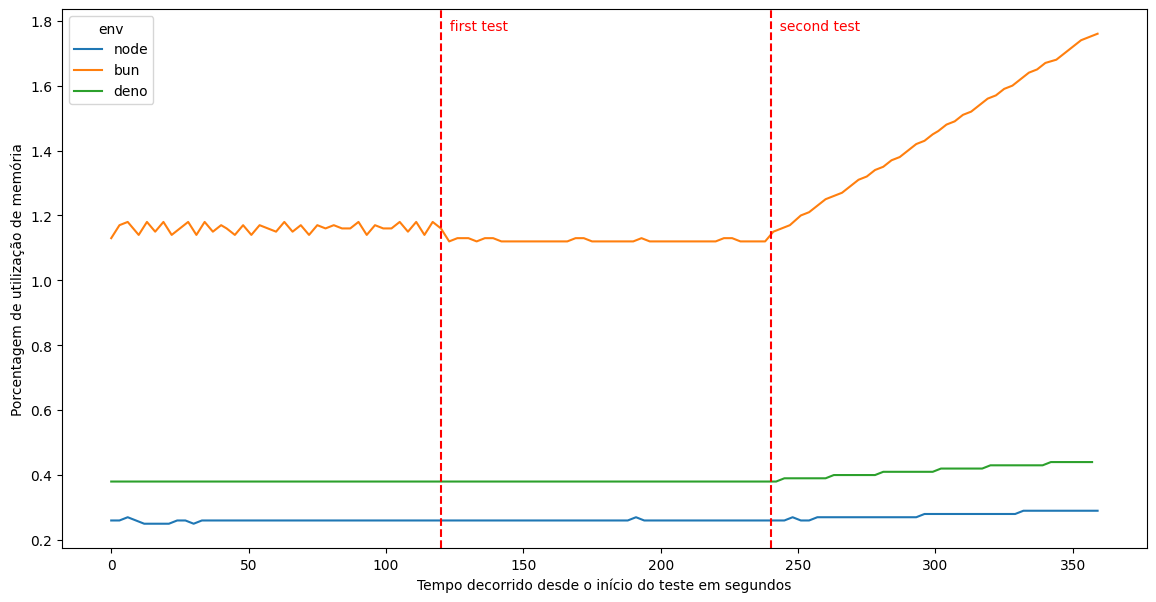

In [44]:
plot_line(filtered_df, 'time_elapsed', 'memory_percentage', 'env', 'Tempo decorrido desde o início do teste em segundos', 'Porcentagem de utilização de memória', test_time_segments)